In [8]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import tensorflow.lite as tflite
# import tensorflowjs as tfjs

In [9]:
img_size = (128,128)
batch_size =  32

train_dataset = image_dataset_from_directory(
    "archive_23/train",
    image_size=img_size,
    batch_size=batch_size,
)

valid_dataset = image_dataset_from_directory(
    "archive_23/valid",
    image_size=img_size,
    batch_size=batch_size,
)

test_dataset = image_dataset_from_directory(
    "archive_23/test",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

class_names = train_dataset.class_names
print("Class Names:", class_names)

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Class Names: ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of h

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

normalization_layer = layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomRotation(0.05),
#     tf.keras.layers.RandomZoom(0.05),
# ])

# # Apply augmentation only to the training set
# def augment(image, label):
#     return data_augmentation(image), label

# train_dataset = train_dataset.map(augment)

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [18]:
model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (3,3), padding="same", kernel_regularizer=regularizers.l2(0.001 ), input_shape=(128, 128, 3)),
    BatchNormalization(),  # Place before activation
    layers.Activation("relu"),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),

    # Second Convolutional Block
    layers.Conv2D(64, (3,3), padding="same", kernel_regularizer=regularizers.l2(0.001 )),
    BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),

    # Third Convolutional Block
    layers.Conv2D(128, (3,3), padding="same", kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.3),
    
    # Fourth Convolutional Block
    layers.Conv2D(256, (3,3), padding="same", kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.3),

    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(384, kernel_regularizer=regularizers.l2(0.001)),  # L2 Regularization
    BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),
    
    layers.Dense(len(class_names), activation="softmax")  # Output layer
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])

# Display model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 384)            │     6,291,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 384)            │         1,53

 Total params: 6,704,117 (25.57 MB)

 Trainable params: 6,702,389 (25.57 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [19]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6)

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True)

In [20]:
def graph():
    # Extract accuracy and loss values
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.show()

In [21]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=25,
    callbacks=[reduce_lr,early_stop,model_checkpoint] #early_stop
)

Epoch 1/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.1835 - loss: 4.6419

239/239 ━━━━━━━━━━━━━━━━━━━━ 147s 602ms/step - accuracy: 0.1839 - loss: 4.6401 - val_accuracy: 0.0943 - val_loss: 5.4972 - learning_rate: 0.0010
Epoch 2/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.3917 - loss: 3.5685

239/239 ━━━━━━━━━━━━━━━━━━━━ 148s 617ms/step - accuracy: 0.3919 - loss: 3.5681 - val_accuracy: 0.4415 - val_loss: 3.4345 - learning_rate: 0.0010
Epoch 3/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.5180 - loss: 3.1713

239/239 ━━━━━━━━━━━━━━━━━━━━ 146s 608ms/step - accuracy: 0.5181 - loss: 3.1709 - val_accuracy: 0.5887 - val_loss: 2.9464 - learning_rate: 0.0010
Epoch 4/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.6279 - loss: 2.9291

239/239 ━━━━━━━━━━━━━━━━━━━━ 142s 595ms/step - accuracy: 0.6280 - loss: 2.9289 - val_accuracy: 0.7472 - val_loss: 2.5344 - learning_rate: 0.0010
Epoch 5/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.6887 - loss: 2.7958

239/239 ━━━━━━━━━━━━━━━━━━━━ 147s 613ms/step - accuracy: 0.6887 - loss: 2.7957 - val_accuracy: 0.7547 - val_loss: 2.5688 - learning_rate: 0.0010
Epoch 6/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.7233 - loss: 2.7849

239/239 ━━━━━━━━━━━━━━━━━━━━ 148s 620ms/step - accuracy: 0.7233 - loss: 2.7847 - val_accuracy: 0.7925 - val_loss: 2.5284 - learning_rate: 0.0010
Epoch 7/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.7669 - loss: 2.7246

239/239 ━━━━━━━━━━━━━━━━━━━━ 142s 595ms/step - accuracy: 0.7670 - loss: 2.7245 - val_accuracy: 0.8340 - val_loss: 2.4999 - learning_rate: 0.0010
Epoch 8/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 141s 588ms/step - accuracy: 0.7784 - loss: 2.7632 - val_accuracy: 0.6528 - val_loss: 3.1253 - learning_rate: 0.0010
Epoch 9/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.7888 - loss: 2.7966

239/239 ━━━━━━━━━━━━━━━━━━━━ 137s 572ms/step - accuracy: 0.7888 - loss: 2.7966 - val_accuracy: 0.8830 - val_loss: 2.5780 - learning_rate: 0.0010
Epoch 10/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 135s 564ms/step - accuracy: 0.8074 - loss: 2.7697 - val_accuracy: 0.8830 - val_loss: 2.4816 - learning_rate: 0.0010
Epoch 11/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 135s 564ms/step - accuracy: 0.8229 - loss: 2.7061 - val_accuracy: 0.8226 - val_loss: 2.7323 - learning_rate: 0.0010
Epoch 12/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 145s 606ms/step - accuracy: 0.8069 - loss: 2.8516 - val_accuracy: 0.8453 - val_loss: 2.8158 - learning_rate: 0.0010
Epoch 13/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.8348 - loss: 2.8279

239/239 ━━━━━━━━━━━━━━━━━━━━ 146s 612ms/step - accuracy: 0.8349 - loss: 2.8277 - val_accuracy: 0.8943 - val_loss: 2.5388 - learning_rate: 0.0010
Epoch 14/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 147s 613ms/step - accuracy: 0.8326 - loss: 2.7699 - val_accuracy: 0.8755 - val_loss: 2.5844 - learning_rate: 0.0010
Epoch 15/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 145s 606ms/step - accuracy: 0.8453 - loss: 2.8333 - val_accuracy: 0.8340 - val_loss: 2.8491 - learning_rate: 0.0010
Epoch 16/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.8484 - loss: 2.8024

239/239 ━━━━━━━━━━━━━━━━━━━━ 149s 624ms/step - accuracy: 0.8484 - loss: 2.8022 - val_accuracy: 0.8981 - val_loss: 2.5783 - learning_rate: 0.0010
Epoch 17/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.8543 - loss: 2.7402

239/239 ━━━━━━━━━━━━━━━━━━━━ 155s 647ms/step - accuracy: 0.8543 - loss: 2.7402 - val_accuracy: 0.9057 - val_loss: 2.5487 - learning_rate: 0.0010
Epoch 18/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 153s 639ms/step - accuracy: 0.8576 - loss: 2.7257 - val_accuracy: 0.8566 - val_loss: 2.7535 - learning_rate: 0.0010
Epoch 19/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 144s 603ms/step - accuracy: 0.8609 - loss: 2.7561 - val_accuracy: 0.8113 - val_loss: 2.8683 - learning_rate: 0.0010
Epoch 20/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 149s 621ms/step - accuracy: 0.8706 - loss: 2.7160 - val_accuracy: 0.8906 - val_loss: 2.6051 - learning_rate: 0.0010
Epoch 21/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.8717 - loss: 2.7063

239/239 ━━━━━━━━━━━━━━━━━━━━ 147s 616ms/step - accuracy: 0.8717 - loss: 2.7062 - val_accuracy: 0.9321 - val_loss: 2.4890 - learning_rate: 0.0010
Epoch 22/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.8681 - loss: 2.7030

239/239 ━━━━━━━━━━━━━━━━━━━━ 151s 629ms/step - accuracy: 0.8681 - loss: 2.7030 - val_accuracy: 0.9472 - val_loss: 2.4578 - learning_rate: 0.0010
Epoch 23/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 149s 623ms/step - accuracy: 0.8660 - loss: 2.7335 - val_accuracy: 0.9019 - val_loss: 2.6398 - learning_rate: 0.0010
Epoch 24/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 145s 605ms/step - accuracy: 0.8795 - loss: 2.7063 - val_accuracy: 0.9283 - val_loss: 2.5149 - learning_rate: 0.0010
Epoch 25/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 146s 609ms/step - accuracy: 0.8832 - loss: 2.6607 - val_accuracy: 0.8717 - val_loss: 2.6326 - learning_rate: 0.0010


In [22]:
test_loss, test_acc = model.evaluate(test_dataset)
print("Test Accuracy:", test_acc)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9540 - loss: 2.4387
Test Accuracy: 0.9283018708229065


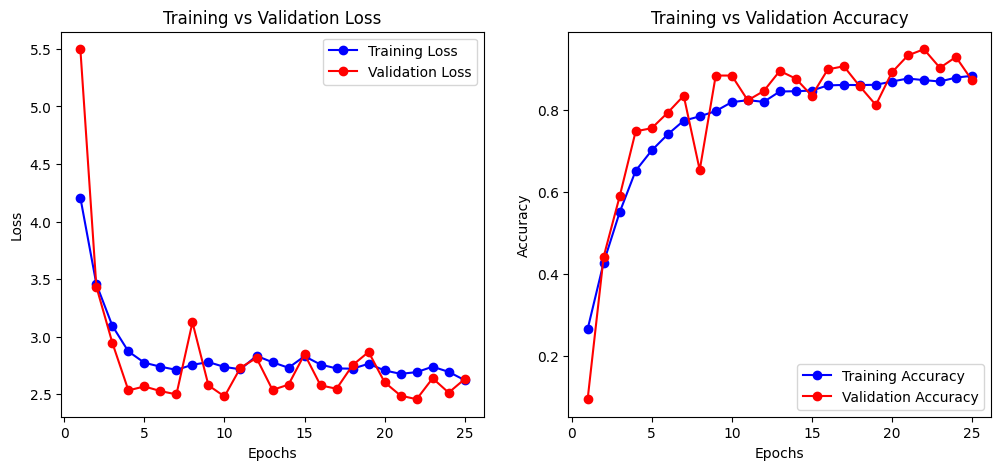

In [23]:
graph()

In [17]:
converter = tflite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF-Lite model
with open("model.tflite", "wb") as f:
    f.write(tflite_model)
    

tfjs.converters.save_keras_model(model, "tfjs_model")

NameError: name 'tflite' is not defined